In [2]:
''' ALL IMPORTS AND LIBRARY SETUPS HERE '''
#import json
import pickle

import plotly.plotly as py

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tweepy
#from textblob import TextBlob
import datetime

from random import randint

import operator
from collections import OrderedDict

import plotly.graph_objs as go

# import all nltk files
import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#from tempfile import TemporaryFile

print("all imports complete")

all imports complete


C:\Users\Benjamin\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [69]:
''' SET UP CONNECTION TO TWITTER ACCOUNT '''

token_key = '839310674635419649-yC6jfbvEFXM4PtdTPBI0vFBRPQ4lHtQ'
token_secret = 'pPHifijyZrFTpG4VeP4k8Kh87kEw8vYDq2WKvvVVMfdbm'
con_secret = 'z4F2ibb2GLBMgRGUcDRxIWv8YlQrQsKtvYpY8Frb79hvLnYHMb'
con_key = 'Ax13skvsMd15qStr9XMgULYJ1'

auth = tweepy.OAuthHandler(con_key, con_secret)
auth.set_access_token(token_key, token_secret)

api = tweepy.API(auth)

print("twitter setup complete")

twitter setup complete


In [153]:
''' SEARCH TWEETS '''

query = 'nasdaq'
max_tweets = 10000
day = datetime.datetime.now().day
month = datetime.datetime.now().month
results = []
last_id = -1
while len(results) < max_tweets:
    count = max_tweets - len(results)
    try:
        new_tweets = api.search(q=query, count=count, max_id=str(last_id - 1),lang='en')
        if not new_tweets:
            break
        results.extend(new_tweets)
        last_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        break

print("available tweets: %d" % len(results))

available tweets: 10000


In [173]:
''' SAVE TWEETS AND DATE '''

tweet_file = open('tweets.pickle', 'wb')
pickle.dump(results, tweet_file)
tweet_file.close()
date_file = open('date.pickle', 'wb')
pickle.dump(day, date_file)
date_file.close()

print('tweets and date saved')

tweets and date saved


In [3]:
''' LOAD TWEETS AND DATE AND SAMPLES ACCESSED '''

tweet_file = open('tweets.pickle', 'rb')
results = pickle.load(tweet_file)
tweet_file.close()
date_file = open('date.pickle', 'rb')
day = pickle.load(date_file)
date_file.close()
sample_file = open('sample.pickle', 'rb')
sample = pickle.load(sample_file)
sample_file.close()

print('tweets, date, and samples accessed %s' % day)

tweets, date, and samples accessed 11


In [4]:
''' TEXT PROCESSING AND ORGANIZATION OF TWEETS '''

tweets = list()
corpus = list()
wordcount = {}
hashcount = {}
stopwords = ['via','by','an','ag','this','into','about','co','our','for'
             ,'as','gets','next','you','with','from','my','live','why','when'
             ,'a','the','i','of','at','it','be','to','are','in','v','htt'
             ,'and','on','after','is']

for result in results:
    if result.created_at.day != (day-0):
        continue
        
    ''' CLEANING TEXT '''
    text = result.text
    polarity = 0
    # remove url's
    while text.__contains__('htt'):
        i = text.index('htt')
        while i < len(text) and text[i] != ' ':
            text = text[:i] + text[(i + 1):]
    # remove rt @user
    while text.__contains__('RT @'):
        i = text.index('RT @')
        while i < len(text) and text[i] != ' ':
            text = text[:i] + text[(i + 1):]
    # remove @user
    while text.__contains__('@'):
        i = text.index('@')
        while i < len(text) and text[i] != ' ':
            text = text[:i] + text[(i + 1):]
    # handle stock quotes
    while text.__contains__('-'):
        i = text.index('-')
        if i < len(text)-1 and text[i+1].isdigit():
            polarity -= 1
            while i < len(text) and text[i] != ' ':
                text = text[:i] + text[(i + 1):]
        else:
            text = text.replace('-',' ')
    while text.__contains__('+'):
        i = text.index('+')
        if i < len(text)-1 and text[i+1].isdigit():
            polarity += 1
            while i < len(text) and text[i] != ' ':
                text = text[:i] + text[(i + 1):]
        else:
            text = text.replace('+',' ')
    
    ''' FREQUENCY OF HASHTAGS '''
    
    hashtags = list()
    for hashtag in text.split():
        if hashtag.__contains__('#'):
            hashtags.append(hashtag)
            text = text.replace(hashtag,'') # remove hashtags
            i = hashtag.index('#')
            hashtag = hashtag[:i] + hashtag[(i+1):]
            if hashtag not in hashcount:
                hashcount[hashtag] = 1
            else:
                hashcount[hashtag] += 1
                
    
    ''' ADDITIONAL CLEANING OF TEXT '''
    
    for stopword in stopwords:
        if text.__contains__(' '+stopword+' '):
            text = text.replace(' '+stopword+' ',' ')
    i = 0
    while i < len(text):
        if text[i].isalpha() or text[i] == ' ':
            if i != 0 and text[i] == ' ' and text[i-1] == ' ':
                text = text[:i] + text[(i+1):]
            else:
                i += 1
        else:
            text = text[:i] + text[(i + 1):]
    text = text.strip()
    text = text.lower()
    
    ''' LEMMATIZER FORMATTING '''
    
    for word in text.split():
        # remove stopwords
        if word in stopwords:
            # remove word by not adding it to list
            continue
        #stemmed_tokens = [porter_stemmer.stem(word)]
        lemmatized_tokens = [wordnet_lemmatizer.lemmatize(word), wordnet.ADJ]
        lemmatized_tokens2 = [wordnet_lemmatizer.lemmatize(word), wordnet.VERB]
    
    ''' FREQUENCY OF WORDS '''
    
    for word in text.split():
        corpus.append(word)
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1

    ''' PRELIMINARY SENTIMENT ANALYSIS '''
    # apply sentiment to tweets with current quantitative stock changes
    
    if polarity > 0:
        polarity = 1
    elif polarity < 0:
        polarity = -1
    
    tweets.append({'text':text,'time':result.created_at,'rt_num':result.retweet_count,
                   'polarity':[polarity, 0, 0],'orig_text':result.text,
                   'hashtags':hashtags,'lemmatized_words':(lemmatized_tokens+lemmatized_tokens2),
                   'user':result.user.name})
    
print('number of tweets being used: %d \n    (from %s to 23:59:59)' % (len(tweets),
    tweets[-1]['time']))
for tweet in tweets:
    print("(created_at: %s, Polarity: %d, RT's: %d) tweet: %s %s" % (tweet['time'],tweet['polarity'][0],
                                                                     tweet['rt_num'],tweet['text'],tweet['hashtags']))
    #print("1) %s\n2) %s" % (tweet['orig_text'],tweet['text']))


number of tweets being used: 6145 
    (from 2017-05-11 00:00:04 to 23:59:59)
(created_at: 2017-05-11 23:59:41, Polarity: 0, RT's: 10) tweet: insider trading activity blucora inc nasdaqbcor director sold shares stock bcor []
(created_at: 2017-05-11 23:59:35, Polarity: 0, RT's: 0) tweet: screen holdings co upgraded zacks investment research buy pt dinrf ['#DINRF']
(created_at: 2017-05-11 23:59:34, Polarity: 0, RT's: 0) tweet: clean energy fuels corp downgraded zacks investment research hold clne ['#CLNE']
(created_at: 2017-05-11 23:59:33, Polarity: 0, RT's: 0) tweet: commercehub upgraded zacks investment research buy pt chuba ['#CHUBA']
(created_at: 2017-05-11 23:59:32, Polarity: 0, RT's: 0) tweet: bg staffing upgraded zacks investment research buy pt bgsf ['#BGSF']
(created_at: 2017-05-11 23:59:30, Polarity: 0, RT's: 0) tweet: auxilio downgraded zacks investment research sell auxo ['#AUXO']
(created_at: 2017-05-11 23:59:28, Polarity: 0, RT's: 0) tweet: appfolio upgraded zacks investmen

In [5]:
''' PRELIMINARY SENTIMENT ANALYSIS AND SETUP TOKEN COUNT '''

# common words associated with stock markets -- (does not consider the context of text)
pos_words = ['buy','invest','buying','up','high','more','rose'
             ,'positive','bullish','bull','rally','rebound','gain']
neg_words = ['sell','cut','selling','down','low','less','downgraded'
             ,'fell','negative','bearish','bear','loss']

for tweet in tweets:
    score = 0
    for token in tweet['lemmatized_words']:
        if token in pos_words:
            score+=1
        if token in neg_words:
            score-=1
    tweet['polarity'][0] = score
    
tokencount = {}
stop_tokens = ['a','v']

for tweet in tweets:
    for token in tweet['lemmatized_words']:
        if token in stop_tokens:
            continue
        if token not in tokencount:
            tokencount[token] = 1
        else:
            tokencount[token] += 1
            
tokencount = OrderedDict(sorted(tokencount.items(),key=operator.itemgetter(1)))
print('Preliminary analysis complete')

Preliminary analysis complete


In [21]:
''' TWEETS WITH MANY RETWEETS '''

rts = dict()
for tweet in tweets:
    if tweet['rt_num'] > 100:
        if tweet['text'] not in rts:
            rts[tweet['text']] = tweet['rt_num']
            print('%d retweets : @%s : %s\n    -%s\n' % (tweet['rt_num'],tweet['user'],tweet['time'],tweet['orig_text']))

7294 retweets : @Madeleine Sanderson : 2017-05-11 22:21:35
    -RT @financialbuzz: Watch Us Report LIVE from the NASDAQ MarketSite! This weeks weekly wrap-up includes $VRX $GIL $ARIA $NASDAQ $NYSE https:…

123 retweets : @Lillian Langdon : 2017-05-11 21:55:15
    -RT @financialbuzz: Watch Us Report LIVE from the NYSE! This weeks weekly wrap-up includes $TGT $NFLX $MS $TIF $NASDAQ $NYSE #Netflix https:…

5827 retweets : @Babybam ♡ : 2017-05-11 21:36:13
    -RT @ganpppp: 3rd Anniversay Support on Jan 16th
Time Square NASDAQ LED
From Chinese IGOT7 
@7GOTher @ganpppp @LetUseeMe 
#GOT7 #갓세븐 #GOT73r…

236 retweets : @Un Rupok : 2017-05-11 20:39:08
    -RT @sphreco: How #blockchain tech will create a distributed future for the energy sector: https://t.co/MvEDDVgD1Z via @NASDAQ

255 retweets : @Un Rupok : 2017-05-11 20:38:18
    -RT @sphreco: 4 use cases for #blockchain technology in banking: https://t.co/GMbkNsxZlm via @NASDAQ #fintech

330 retweets : @Un Rupok : 2017-05-11 20:35:36
    -RT @

OrderedDict([('more', 54), ('analysis', 62), ('bell', 64), ('market', 64), ('level', 66), ('gtgt', 70), ('soon', 80), ('condition', 86), ('lease', 98), ('plunge', 100), ('inc', 104), ('story', 120), ('high', 136), ('result', 144), ('stock', 304), ('nasdaq', 574), ('further', 2058)])


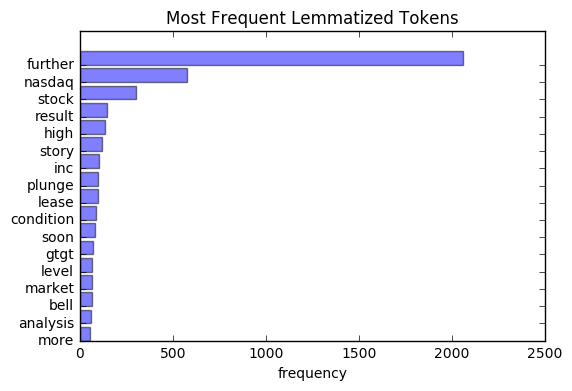

In [7]:
''' DISPLAY MOST FREQUENT LEMMATIZED TOKENS '''

temp = tokencount
temp = {key: value for key, value in temp.items() 
             if value > 50}
temp = OrderedDict(sorted(temp.items(),key=operator.itemgetter(1)))
print(temp)

objects = temp.keys()
y_pos = np.arange(len(objects))
performance = temp.values()

plt.barh(y_pos, performance, alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('frequency')
plt.title('Most Frequent Lemmatized Tokens')
 
plt.show()

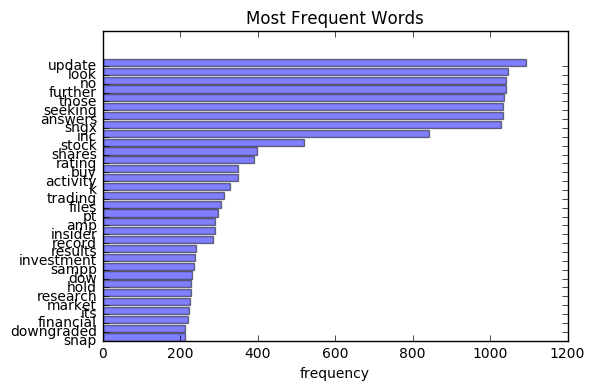

In [8]:
''' DISPLAY MOST FREQUENT WORDS '''

temp = wordcount
temp = {key: value for key, value in temp.items() 
             if value > 200 and key not in stopwords}
temp = OrderedDict(sorted(temp.items(),key=operator.itemgetter(1)))
del temp['nasdaq']

objects = temp.keys()
y_pos = np.arange(len(objects))
performance = temp.values()

plt.barh(y_pos, performance, alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('frequency')
plt.title('Most Frequent Words')
 
plt.show()

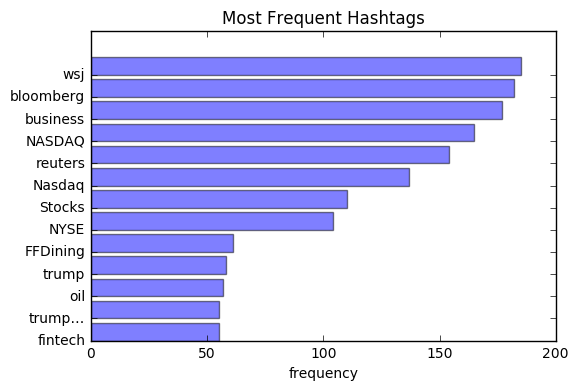

In [9]:
''' DISPLAY MOST FREQUENT HASHTAGS '''

temp = hashcount
temp = {key: value for key, value in temp.items() 
             if value > 50}
temp = OrderedDict(sorted(temp.items(),key=operator.itemgetter(1)))
del temp['nasdaq']

objects = temp.keys()
y_pos = np.arange(len(objects))
performance = temp.values()

plt.barh(y_pos, performance, alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('frequency')
plt.title('Most Frequent Hashtags')
 
plt.show()

In [10]:
''' SETUP TIME SERIES OF POLARITY '''
time_polarity = list()
time_polarity.append([0]*1440)
pos_num1 = 0
neg_num1 = 0
zero_num1 = 0

for tweet in tweets:
    pos = tweet['time'].hour*60+tweet['time'].minute
    if tweet['polarity'][0] < 0:
        neg_num1 += 1
    elif tweet['polarity'][0] > 0:
        pos_num1 += 1
    else:
        zero_num1 += 1
        
    for i in range(pos,len(time_polarity[0])):
        time_polarity[0][i] += tweet['polarity'][0]
        
print('1440 seconds in day | %d compononents of time_polarity collected' % len(time_polarity[0]))

1440 seconds in day | 1440 compononents of time_polarity collected


In [12]:
''' ACQUIRING AND CREATING SAMPLE FOR TRAINING AND TESTING '''
# random sampling was done on tweets collected across 3 different days
# 200 components were created from tweets of 4/19/17
# 200 components were created from tweets of 4/23/17
# 100 components were created from tweets of 4/

if not 'sample' in globals():
    sample_file = open('sample.pickle', 'rb')
    sample = pickle.load(sample_file)
    sample_file.close()
    print('%d samples loaded' % len(sample))
while len(sample) < 500:
    j = randint(0,len(tweets))
    for s in sample[0:len(sample)]:
        if tweets[j]['text'] in s.keys():
            print('finding new j')
            j = randint(0,len(tweets))
            s = 0
    print("%d - %s" % (len(sample),tweets[j]['text']))
    uinput = input("Polarity?(1 or 0 or -1) ")
    if uinput != '1' and uinput != '0' and uinput != '-1':
        sample_file = open('sample.pickle', 'wb')
        pickle.dump(sample, sample_file)
        sample_file.close()
        break    
    sample.append({tweets[j]['text']:uinput})

print(sample)

262 samples loaded
262 - hackers invited to disrupt botswanas electronic voting machines
Polarity?(1 or 0 or -1) 0000
[{'what do delaware and japan have in common trials news': '0'}, {'brief nasdaq launches venture investment program minority stake investments made by nasdaq ventures are exp': '0'}, {'update cps announces first quarter earnings nasdaqcpss globenewswire press release': '0'}, {'apertura en wall street dow jones sampp nasdaq': '0'}, {'ho innovation inc upgraded by zacks investment research to hold heoff': '1'}, {'iphone tsunami coming morgan stanley raises oled apple phone forecast apples shift to the oled': '1'}, {'nasdaq behind the bell': '0'}, {'watch us report live from the nasdaq marketsite this weeks weekly wrap up includes vrx gil aria nasdaq nyse': '0'}, {'caterpillar inc cat ex dividend date scheduled for april nasdaq': '0'}, {'how to invest in the internet of things nasdaq': '0'}, {'ftmr acquires k acres of oil and gas leases': '0'}, {'innd is a fresh one here w

In [11]:
''' LOADING SAMPLE DATA '''

spec = list()
sample_file = open('sample.pickle', 'rb')
sample = pickle.load(sample_file)
sample_file.close()
for s in sample:
    for stopword in stopwords:
            if list(s)[0].__contains__(' '+stopword+' '):
                spec.append({list(s)[0].replace(' '+stopword+' ',' '):list(s.values())[0]})

print(spec)
print('Sample loaded')

[{'what do delaware and japan have common trials news': '0'}, {'what do delaware japan have in common trials news': '0'}, {'brief nasdaq launches venture investment program minority stake investments made nasdaq ventures are exp': '0'}, {'brief nasdaq launches venture investment program minority stake investments made by nasdaq ventures exp': '0'}, {'ho innovation inc upgraded zacks investment research to hold heoff': '1'}, {'ho innovation inc upgraded by zacks investment research hold heoff': '1'}, {'iphone tsunami coming morgan stanley raises oled apple phone forecast apples shift to oled': '1'}, {'iphone tsunami coming morgan stanley raises oled apple phone forecast apples shift the oled': '1'}, {'nasdaq behind bell': '0'}, {'watch us report live from the nasdaq marketsite weeks weekly wrap up includes vrx gil aria nasdaq nyse': '0'}, {'watch us report live the nasdaq marketsite this weeks weekly wrap up includes vrx gil aria nasdaq nyse': '0'}, {'watch us report from the nasdaq mar

In [12]:
''' TRAIN AND TEST NAIVE BAYES ALGORITHM ON SAMPLE DATA '''

import random
random.shuffle(spec)
split = int(len(spec)*.65)
split1, split2 = spec[split:], spec[:split]
train_set = list()
test_set = list()
for tset in split1:
    train_set.append(tuple([list(tset)[0].split()])+tuple(tset.values()))
    #train_set.append(tset.items())
for tset in split2:
    test_set.append(tuple([list(tset)[0].split()])+tuple(tset.values()))
    #test_set.append(tset.items())
print(train_set[0])
print(test_set[0])

sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in train_set])
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
len(unigram_feats)
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

training_set = sentim_analyzer.apply_features(train_set)
test_set = sentim_analyzer.apply_features(test_set)
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)

for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
    print('{0}: {1}'.format(key, value))
    
for tweet in tweets:
    #print(sentim_analyzer.classify(tweet['text'].split()))
    tweet['polarity'][1] = sentim_analyzer.classify(tweet['text'].split())
print(unigram_feats)

(['agrellos', 'ai', 'powered', 'smart', 'contract', 'interface', 'to', 'be', 'built', 'qtum'], '1')
(['bar', 'i', 'developed', 'a', 'loathing', 'for', 'nasdaq', 'between'], '0')
Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.5870307167235495
F-measure [-1]: 0.2222222222222222
F-measure [0]: 0.715686274509804
F-measure [1]: 0.32258064516129026
Precision [-1]: 0.2727272727272727
Precision [0]: 0.6375545851528385
Precision [1]: 0.47619047619047616
Recall [-1]: 0.1875
Recall [0]: 0.8156424581005587
Recall [1]: 0.24390243902439024
['nasdaq', 'to', 'the', 'in', 'on', 'of', 'and', 'amp', 'via', 'for', 'research', 'hold', 'investment', 'pt', 'stock', 'more', 'is', 'this', 'invest', 'a', 'sampp', 'are', 'rating', 'new', 'zacks', 'by', 'futures', 'up', 'inc', 'upgraded', 'europe', 'blockchain', 'news', 'reiterated', 'at', 'wants', 'it', 'index', 'an', 'buy', 'before', 'with', 'us', 'your', 'as', 'corp', 'how', 'why', 'now', 'when', 'startups', 'our', 'watch', 'venture

In [13]:
''' download all nltk packages (one time) '''
#nltk.download('all')

' download all nltk packages (one time) '

In [14]:
''' USE NLTK TO JUDGE SENTIMENT '''

sid = SentimentIntensityAnalyzer()
for tweet in tweets:
    print(tweet['text'])
    ss = sid.polarity_scores(tweet['text'])
    
    for k in sorted(ss):
        if k == 'compound':
            tweet['polarity'][2] = {k:ss[k]}
        else:
            tweet['polarity'][2].update({k:ss[k]})
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

insider trading activity blucora inc nasdaqbcor director sold shares stock bcor
compound: 0.296, neg: 0.0, neu: 0.82, pos: 0.18, 
screen holdings co upgraded zacks investment research buy pt dinrf
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
clean energy fuels corp downgraded zacks investment research hold clne
compound: 0.5859, neg: 0.0, neu: 0.625, pos: 0.375, 
commercehub upgraded zacks investment research buy pt chuba
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
bg staffing upgraded zacks investment research buy pt bgsf
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
auxilio downgraded zacks investment research sell auxo
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
appfolio upgraded zacks investment research strong buy pt appf
compound: 0.5106, neg: 0.0, neu: 0.708, pos: 0.292, 
allied motion technologies upgraded zacks investment research hold amot
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
insider trading activity apollo endosurgery inc nasdaqapen major shareholder sold share

In [15]:
''' SETUP TIME SERIES OF POLARITY '''

interval_polarity = list()
interval_polarity.append(0)

time_polarity.append([0]*1440)
pos_num2 = 0
neg_num2 = 0
zero_num2 = 0

interval_polarity.append(list())
for i in range(96):
    interval_polarity[1].append({})
    interval_polarity[1][i]['tweet_num'] = 0
    interval_polarity[1][i]['time'] = 0
    interval_polarity[1][i]['neg'] = 0
    interval_polarity[1][i]['neu'] = 0
    interval_polarity[1][i]['pos'] = 0
    
time_polarity.append([0]*1440)
pos_num3 = 0
neg_num3 = 0
zero_num3 = 0

interval_polarity.append(list())
for i in range(96):
    interval_polarity[2].append({})
    interval_polarity[2][i]['compound'] = 0
    interval_polarity[2][i]['neg'] = 0
    interval_polarity[2][i]['neu'] = 0
    interval_polarity[2][i]['pos'] = 0

for tweet in tweets:
    
    pos = tweet['time'].hour*60+tweet['time'].minute
    interval = int((tweet['time'].hour*60+tweet['time'].minute)/15)
    
    interval_polarity[2][interval]['compound'] += tweet['polarity'][2]['compound']
    interval_polarity[2][interval]['neg'] += tweet['polarity'][2]['neg']
    interval_polarity[2][interval]['neu'] += tweet['polarity'][2]['neu']
    interval_polarity[2][interval]['pos'] += tweet['polarity'][2]['pos']
    
    #interval_polarity    
    interval_polarity[1][interval]['time'] = '%s:%s' % (tweet['time'].hour,int(tweet['time'].minute/15)*15)
    if tweet['polarity'][1] == '-1':
        interval_polarity[1][interval]['neg'] += 1
        neg_num2 += 1
    elif tweet['polarity'][1] == '1':
        interval_polarity[1][interval]['pos'] += 1
        pos_num2 += 1
    else:
        interval_polarity[1][interval]['neu'] += 1
        zero_num2 += 1
        
    if tweet['polarity'][2]['compound'] < 0:
        neg_num3 += 1
    elif tweet['polarity'][2]['compound'] > 0:
        pos_num3 += 1
    else:
        zero_num3 += 1
        
    interval_polarity[1][interval]['tweet_num'] += 1    
        
    for i in range(pos,len(time_polarity[1])):
        time_polarity[1][i] += int(tweet['polarity'][1])
    for i in range(pos,len(time_polarity[2])):
        time_polarity[2][i] += tweet['polarity'][2]['compound']
        
print(interval_polarity[1][69])
print(interval_polarity[2][69])
print(interval_polarity[1][69]['time'])

print('1440 seconds in day | %d compononents of time_polarity collected' % len(time_polarity[1]))
print('1440 seconds in day | %d compononents of time_polarity collected' % len(time_polarity[2]))

{'neg': 1, 'pos': 3, 'time': '17:15', 'tweet_num': 25, 'neu': 21}
{'compound': 6.084600000000001, 'pos': 4.13, 'neu': 20.522, 'neg': 0.348}
17:15
1440 seconds in day | 1440 compononents of time_polarity collected
1440 seconds in day | 1440 compononents of time_polarity collected


(0.75, 96.75)

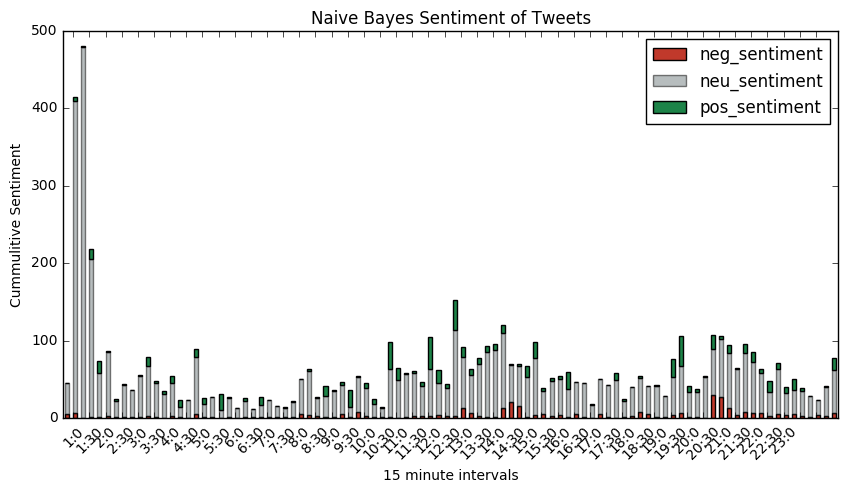

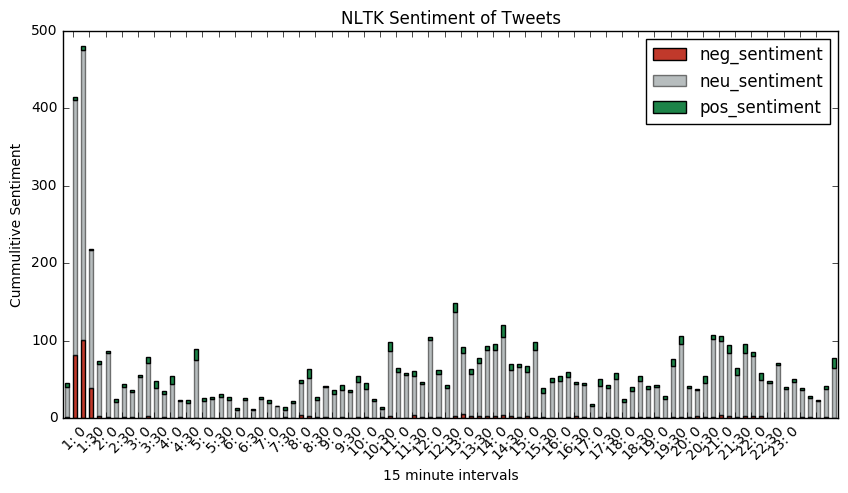

In [16]:
''' 15 MINUTE SEGMENT OF SENTIMENT '''

%matplotlib inline

raw_data = {'time':list(),'neg':list(),'neu':list(),'pos':list()}
i = 0
for inter in interval_polarity[1]:
    raw_data['time'].append(inter['time'])
    raw_data['neg'].append(inter['neg'])
    raw_data['neu'].append(inter['neu'])
    raw_data['pos'].append(inter['pos'])
    i = i + 1
df = pd.DataFrame(raw_data, columns = ['time','neg', 'neu', 'pos'])

f, ax1 = plt.subplots(1, figsize=(10,5))
bar_width = 0.5
bar_l = [i+1 for i in range(len(df['neg']))]
tick_pos = [i+(bar_width/2) for i in bar_l]

ax1.bar(bar_l,df['neg'],width=bar_width,label='neg_sentiment',alpha=1,color='#C0392B')
ax1.bar(bar_l,df['neu'],width=bar_width,bottom=df['neg'],label='neu_sentiment',alpha=0.5,color='#717D7E')
ax1.bar(bar_l,df['pos'],width=bar_width,bottom=[i+j for i,j in zip(df['neg'],df['neu'])],label='pos_sentiment',alpha=1,color='#1D8348')

# Set the label and legends
ax1.set_ylabel("Cummulitive Sentiment")
ax1.set_xlabel("15 minute intervals")
plt.legend(loc='upper right')
plt.title('Naive Bayes Sentiment of Tweets')

time = list()
for i in range(48):
    time.append(raw_data['time'][i*2])
plt.xticks(np.arange(48)*2.0, time[1:-1], rotation=45)
#plt.xticks(np.arange(96), raw_data['time'][1:-1], rotation=45)

# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

raw_data = {'time':list(),'neg':list(),'neu':list(),'pos':list()}
i = 0
for inter in interval_polarity[2]:
    raw_data['time'].append('%2d:%2d' % (int(i/4),i%4*15))
    raw_data['neg'].append(inter['neg'])
    raw_data['neu'].append(inter['neu'])
    raw_data['pos'].append(inter['pos'])
    i = i + 1
df = pd.DataFrame(raw_data, columns = ['time','neg', 'neu', 'pos'])

f, ax1 = plt.subplots(1, figsize=(10,5))
bar_width = 0.5
bar_l = [i+1 for i in range(len(df['neg']))]
tick_pos = [i+(bar_width/2) for i in bar_l]

ax1.bar(bar_l,df['neg'],width=bar_width,label='neg_sentiment',alpha=1,color='#C0392B')
ax1.bar(bar_l,df['neu'],width=bar_width,bottom=df['neg'],label='neu_sentiment',alpha=0.5,color='#717D7E')
ax1.bar(bar_l,df['pos'],width=bar_width,bottom=[i+j for i,j in zip(df['neg'],df['neu'])],label='pos_sentiment',alpha=1,color='#1D8348')
# set the x ticks with names
#plt.xticks(tick_pos, df['time'])

# Set the label and legends
ax1.set_ylabel("Cummulitive Sentiment")
ax1.set_xlabel("15 minute intervals")
plt.legend(loc='upper right')
plt.title('NLTK Sentiment of Tweets')
time = list()
for i in range(48):
    time.append(raw_data['time'][i*2])
plt.xticks(np.arange(48)*2.0, time[1:-1], rotation=45)
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])



(0.75, 96.75)

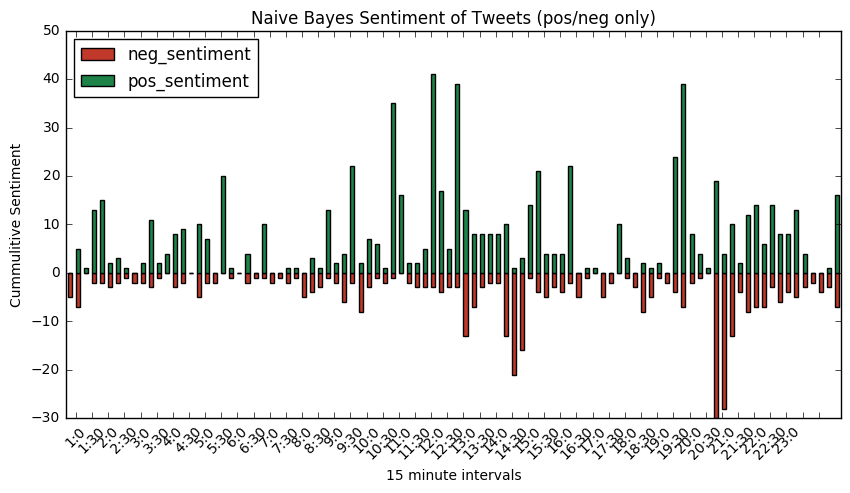

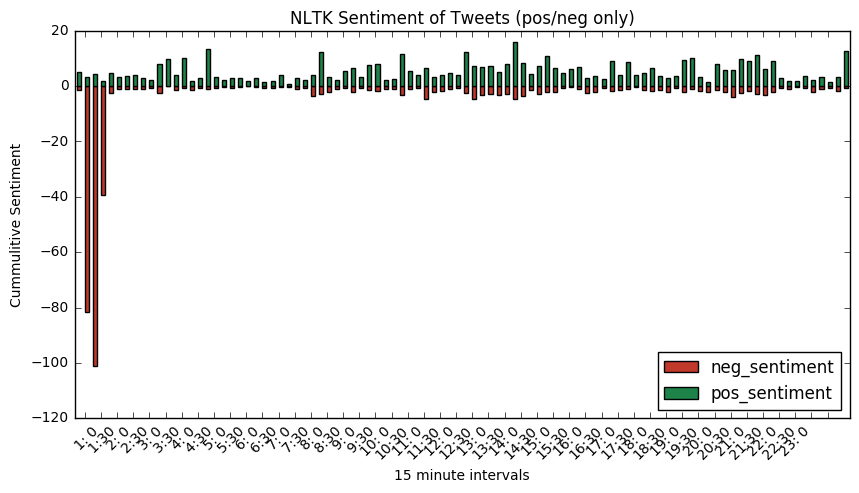

In [20]:
''' POS/NEG ONLY INTERVAL SENTIMENT '''

raw_data = {'time':list(),'neg':list(),'pos':list()}

for inter in interval_polarity[1]:
    raw_data['time'].append(inter['time'])
    raw_data['neg'].append(inter['neg']*(-1))
    raw_data['pos'].append(inter['pos'])
df = pd.DataFrame(raw_data, columns = ['time','neg', 'pos'])

f, ax1 = plt.subplots(1, figsize=(10,5))
bar_width = 0.5
bar_l = [i+1 for i in range(len(df['neg']))]
tick_pos = [i+(bar_width/2) for i in bar_l]

ax1.bar(bar_l,df['neg'],width=bar_width,label='neg_sentiment',alpha=1,color='#C0392B')
ax1.bar(bar_l,df['pos'],width=bar_width,label='pos_sentiment',alpha=1,color='#1D8348')

# Set the label and legends
ax1.set_ylabel("Cummulitive Sentiment")
ax1.set_xlabel("15 minute intervals")
plt.legend(loc='upper left')
plt.title('Naive Bayes Sentiment of Tweets (pos/neg only)')

time = list()
for i in range(48):
    time.append(raw_data['time'][i*2])
plt.xticks(np.arange(48)*2.0, time[1:-1], rotation=45)
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

raw_data = {'time':list(),'neg':list(),'pos':list()}

i= 0
for inter in interval_polarity[2]:
    raw_data['time'].append('%2d:%2d' % (int(i/4),i%4*15))
    raw_data['neg'].append(inter['neg']*(-1))
    raw_data['pos'].append(inter['pos'])
    i+=1
df = pd.DataFrame(raw_data, columns = ['time','neg', 'pos'])

f, ax1 = plt.subplots(1, figsize=(10,5))
bar_width = 0.5
bar_l = [i+1 for i in range(len(df['neg']))]
tick_pos = [i+(bar_width/2) for i in bar_l]

ax1.bar(bar_l,df['neg'],width=bar_width,label='neg_sentiment',alpha=1,color='#C0392B')
ax1.bar(bar_l,df['pos'],width=bar_width,label='pos_sentiment',alpha=1,color='#1D8348')

# Set the label and legends
ax1.set_ylabel("Cummulitive Sentiment")
ax1.set_xlabel("15 minute intervals")
plt.legend(loc='lower right')
plt.title('NLTK Sentiment of Tweets (pos/neg only)')

time = list()
for i in range(48):
    time.append(raw_data['time'][i*2])
plt.xticks(np.arange(48)*2.0, time[1:-1], rotation=45)
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

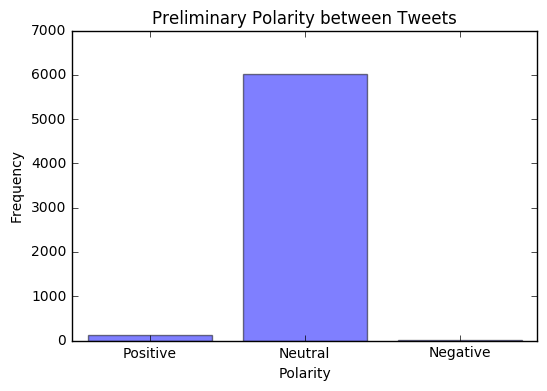

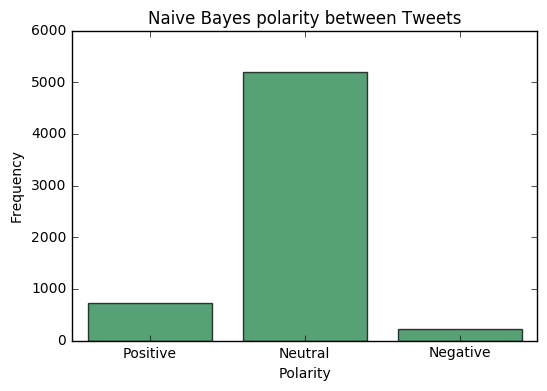

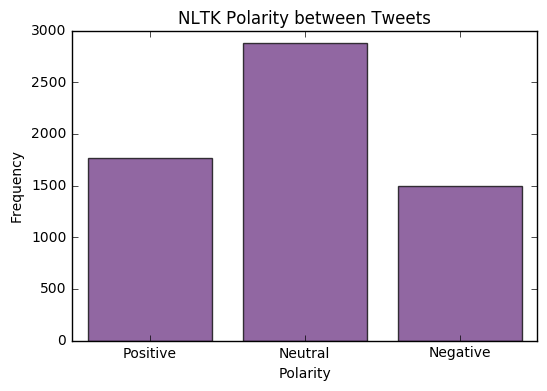

In [168]:
''' DISPLAY DISTRIBUTION OF POLARITY BETWEEN TWEETS '''

performance = [pos_num1,zero_num1,neg_num1]
objects = ('Positive','Neutral','Negative')
y_pos = np.arange(len(objects))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.xlabel('Polarity')
plt.title('Preliminary Polarity between Tweets')
 
plt.show()

performance = [pos_num2,zero_num2,neg_num2]
objects = ('Positive','Neutral','Negative')
y_pos = np.arange(len(objects))

plt.bar(y_pos, performance, align='center', alpha=0.75,color = '#1D8348')
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.xlabel('Polarity')
plt.title('Naive Bayes polarity between Tweets')
 
plt.show()

performance = [pos_num3,zero_num3,neg_num3]
objects = ('Positive','Neutral','Negative')
y_pos = np.arange(len(objects))

plt.bar(y_pos, performance, align='center', alpha=0.75,color = '#6C3483')
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.xlabel('Polarity')
plt.title('NLTK Polarity between Tweets')
 
plt.show()

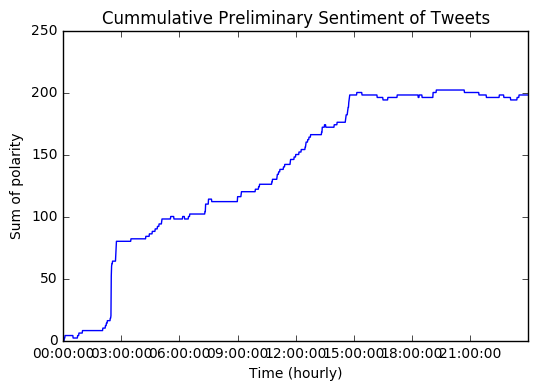

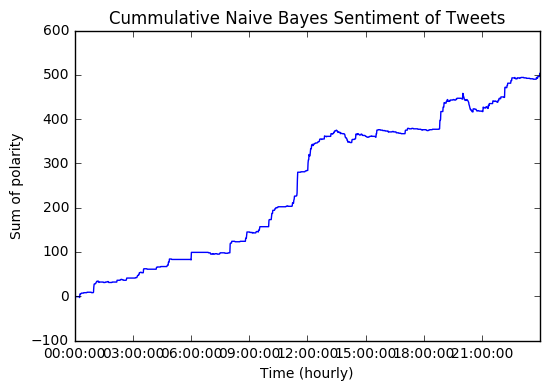

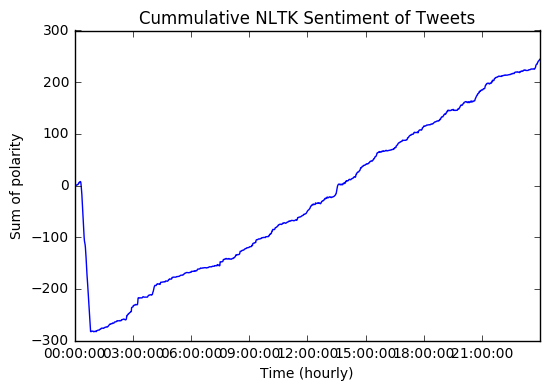

In [169]:
''' DISPLAY TIME SERIES OF POLARITY '''

#x = range(1440)
x = np.array([datetime.datetime(2017, 5, day, int(i/60), i%60) for i in range(1440)])
y = time_polarity[0]
plt.ylabel('Sum of polarity')
plt.xlabel('Time (hourly)')
plt.title('Cummulative Preliminary Sentiment of Tweets')

plt.plot(x,y)

plt.show()

#x = range(1440)
x = np.array([datetime.datetime(2017, 5, day, int(i/60), i%60) for i in range(1440)])
y = time_polarity[1]
plt.ylabel('Sum of polarity')
plt.xlabel('Time (hourly)')
plt.title('Cummulative Naive Bayes Sentiment of Tweets')
 
plt.plot(x,y)
plt.show()

#x = range(1440)
x = np.array([datetime.datetime(2017, 5, day, int(i/60), i%60) for i in range(1440)])
y = time_polarity[2]
plt.ylabel('Sum of polarity')
plt.xlabel('Time (hourly)')
plt.title('Cummulative NLTK Sentiment of Tweets')

plt.plot(x,y)
plt.show()

96
96


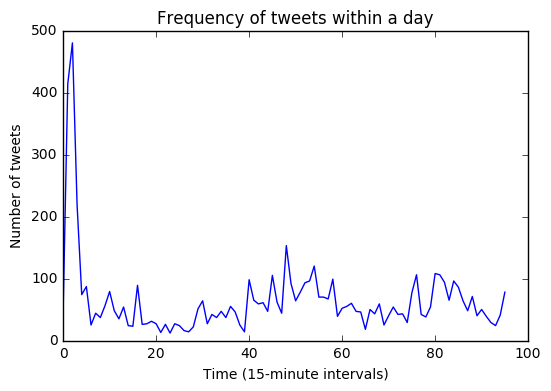

In [22]:
''' FREQUENCY OF TWEETS IN A DAY '''

x = range(96)
#x = np.array([interval_polarity[1][i]['time'] for i in range(len(interval_polarity[1]))])
#x = np.array([datetime.datetime(2017, 4, day, int(i/60), i%60) for i in range(1440)])
print(len(x))
y = np.array([interval_polarity[1][i]['tweet_num'] for i in range(len(interval_polarity[1]))])
print(len(y))
plt.ylabel('Number of tweets')
plt.xlabel('Time (15-minute intervals)')
plt.title('Frequency of tweets within a day')

plt.plot(x,y)
plt.show()